In [1]:
import os
import numpy as np
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from time import time
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim

from torch.utils.tensorboard import SummaryWriter

from functools import reduce

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataloader + downloading dataset

In [302]:
DOWNLOAD = False
TRAIN_VAL_SPLIT = 0.9
batch_size = 64

root = './resources/mnist'
if not os.path.exists(root):
    os.mkdir(root)
    
transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.0,), (1.0,))
                               ])

# Flatten the images into a vector
flatten = lambda x: transforms.ToTensor()(x).view(28**2)

full_train_set = datasets.MNIST(root=root, download=DOWNLOAD, train=True, transform=transform)
test_set = datasets.MNIST(root=root, download=DOWNLOAD, train=False, transform=transform)

num_full_train = len(full_train_set)
train_size = int(TRAIN_VAL_SPLIT * num_full_train)
val_size = num_full_train - train_size
train_set, val_set = torch.utils.data.random_split(full_train_set, [train_size, val_size])

# The digit classes to use
classes = [0,1,2,3,4,5,6,7,8,9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

train_loader = torch.utils.data.DataLoader(dataset=full_train_set,
                                           batch_size=batch_size,
#                                            sampler=stratified_sampler(full_train_set.train_labels),
#                                            shuffle=True
                                          )

val_loader = torch.utils.data.DataLoader(dataset=test_set,
                                         batch_size=batch_size,
#                                          sampler=stratified_sampler(test_set.test_labels),
                                         shuffle=True
                                        )

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
#                                           sampler=stratified_sampler(test_set.test_labels)
#                                           shuffle=False
                                         )

print('Training samples: {}'.format(len(train_set)))
print('Validation samples: {}'.format(len(val_set)))
print('Test samples: {}'.format(len(test_set)))

Training samples: 54000
Validation samples: 6000
Test samples: 10000


In [303]:
len(train_set.indices), len(train_loader)

(54000, 938)

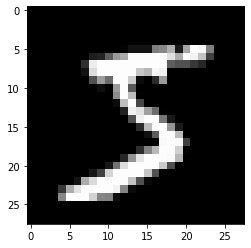

In [304]:
pom, _ = next(iter(train_loader))
pom.shape
plt.imshow(pom[0].view(28,28).numpy(), cmap='gist_gray')

## Auxilary functions

In [91]:
def fig2data(fig):
    """
    Function taken from http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis = 2)
    return buf

## Inspecting the first iteration of images and labels

In [305]:
# get iteration of images and labels to find out its shape
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [306]:
# Minimum and maximum value in the first image (pixel range)
min(images[0].view(-1)), max(images[0].view(-1))

(tensor(0.), tensor(1.))

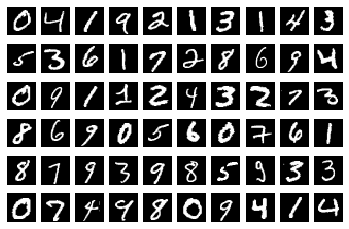

In [307]:
# display 60 images from current iteration
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gist_gray')

# VAE implementation

In [323]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_features = 28*28
latent_features = 2

class Net(nn.Module):
    
    def __init__(self, latent_features=2):
        super(Net, self).__init__()
        
        self.latent_features = latent_features
        
        self.encoder = nn.Sequential(
#             nn.Linear(num_features, 120),
#             nn.ReLU(),
#             nn.Linear(120, 2*latent_features)
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2*latent_features)
        )
        
        self.decoder = nn.Sequential(
#             nn.Linear(latent_features, 120),
#             nn.ReLU(),
#             nn.Linear(120, num_features),
            nn.Linear(latent_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_features),
            nn.Sigmoid()
        )
        
    def reparametrization_trick(self, mu, log_var):
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.latent_features).to(device)
#             epsilon = torch.randn_like(log_var).to(device)
        # log(sigma^2) = log_var  =>  e^(log_var) = sigma^2  =>  sigma = e^(log_var / 2)
        sigma = torch.exp(log_var / 2)
        z = mu + sigma * epsilon
        return z
    
    def get_z(self, x):
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        return mu
        
    def forward(self, x):
        initial_shape = x.shape
        x = x.view(initial_shape[0], -1)
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        # Make sure that the log variance is positive
        log_var = F.softplus(log_var)
#         print('mu shape:', mu.shape)
        z = self.reparametrization_trick(mu, log_var)  # sample from mu + sigma * epsilon, where epsilon ~ N(0,1)
        outputs = self.decoder(z)
        outputs = outputs.view(initial_shape)
        return outputs, mu, log_var, z
    
net = Net(latent_features=latent_features).to(device)
print(net)

Net(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [324]:
import torch.optim as optim

def ELBO_loss(x_hat, x, mu, log_var, bernoulli=False):
    
    #TODO: add discretization for use with Bernoulli
    if bernoulli:
        threshold = torch.tensor([0.2])
        x = (x > threshold).float()
    
    likelihood_batch = -F.binary_cross_entropy(x_hat, x, reduction='none') # dimension [batch, [orig_image_dims]]
    # Sum over features
    likelihood_batch = likelihood_batch.view(likelihood_batch.size(0), -1).sum(1)
    
    # KL-divergence = how much information is lost by approximating p(z) by q(z)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
    
    # the evidence lower bound objective (ELBO)
    # use mean over batch
    elbo = torch.mean(likelihood_batch) - torch.mean(kl)
    return -elbo, kl.sum()

# loss_function = nn.MSELoss()
loss_function = ELBO_loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Test the forward pass

In [325]:
# test the forward pass
images, labels = next(iter(train_loader))
images = images.to(device)
print(images.shape)
outputs, mu, log_var, z = net(images)
print(outputs.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


In [326]:
# min and max value of output images (pixel values)
min(outputs.view(-1)), max(outputs.view(-1))

(tensor(0.3212, grad_fn=<SelectBackward>),
 tensor(0.6826, grad_fn=<SelectBackward>))

In [327]:
# Example loss function and output dimensions
loss, kl = loss_function(outputs, images, mu, log_var, bernoulli=True)
print('log var shape:', log_var.shape)
print('mu shape:', mu.shape)
print('loss value:', loss)
print('kl value', kl)

log var shape: torch.Size([64, 2])
mu shape: torch.Size([64, 2])
loss value: tensor(545.3117, grad_fn=<NegBackward>)
kl value tensor(19.1689, grad_fn=<SumBackward0>)


### Save batch of images and network graph to file for displaying in tensorboard

In [20]:
# Save batch of images and network graph to file for displaying in tensorboard
tb = SummaryWriter()

network = Net()
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/jit/__init__.py:914: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%epsilon : Float(64, 2) = aten::randn_like(%log_var, %52, %53, %54, %55), scope: Net # <ipython-input-15-10143e950f0f>:26:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/jit/__init__.py:914: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[54, 0, 8, 7] (0.7348414659500122 vs. 0.16779620945453644) and 50166 other locations (99.00%)
  check_tolerance, _force_outplace, True, _module_class)
/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/jit/__init__.py:

## Train the network

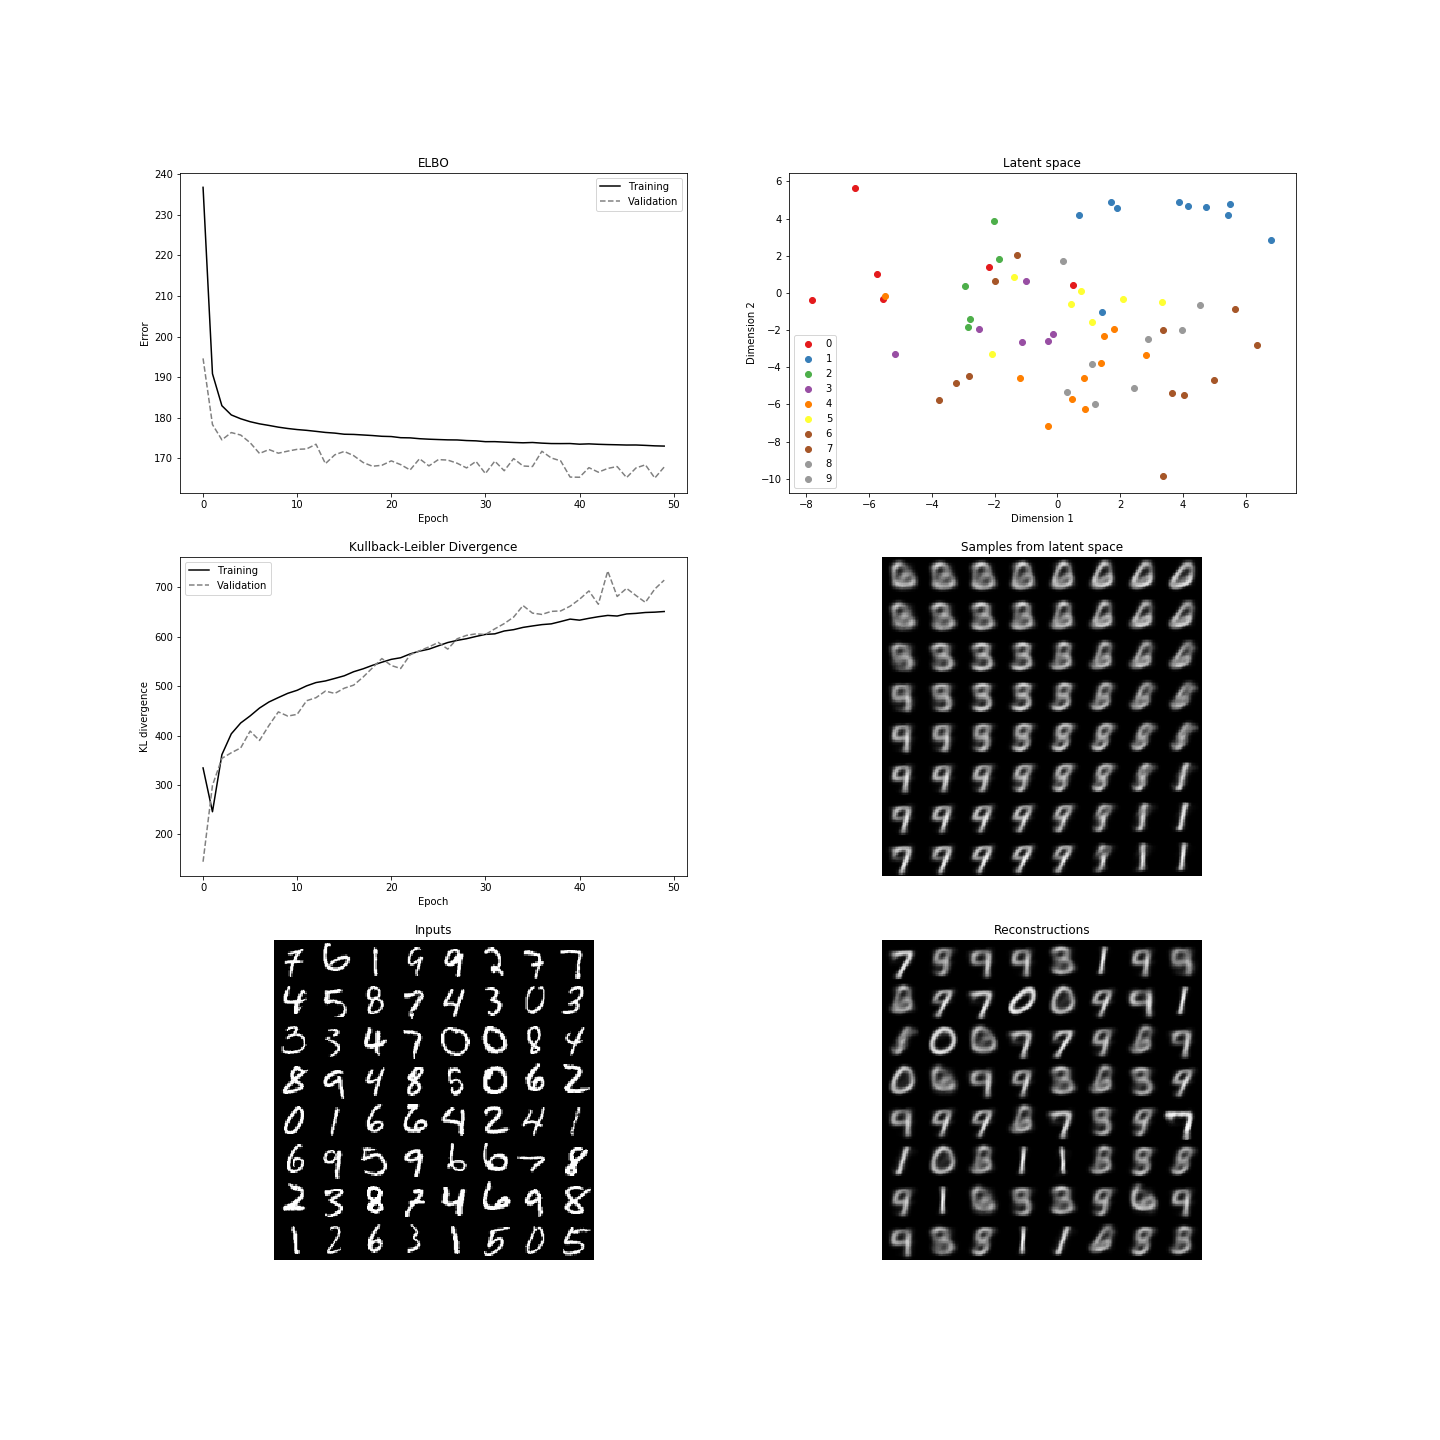

In [328]:
from IPython.display import Image, display, clear_output
# train the network
TF_LOG = False
BERNOULLI = False
train_loss, train_kl = [], []
valid_loss, valid_kl = [], []

print("Using device:", device)

if TF_LOG:
    tb = SummaryWriter()

for epoch in range(50):
    batch_loss, batch_kl = [], []
    net.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # forward + backward + optimize
        ###### discretize inputs
#         threshold = torch.tensor([0.2])
#         inputs = (inputs > threshold).float()
        ######
        x_hat, mu, log_var, _ = net(inputs)
        loss, kl = loss_function(x_hat, inputs, mu, log_var, bernoulli=BERNOULLI)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        batch_kl.append(kl.item())
        # print statistics
        running_loss += loss.item()
#         if i % 100 == 99:
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0
    
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    
    with torch.no_grad():
        net.eval()
        batch_loss, batch_kl = [], []
        
#         for data in test_loader:
        data = next(iter(test_loader))
        inputs, labels = data[0].to(device), data[1].to(device)

        ###### discretize inputs
#         threshold = torch.tensor([0.2])
#         inputs = (inputs > threshold).float()
        ######
        x_hat, mu, log_var, z = net(inputs)

        loss, kl = loss_function(x_hat, inputs, mu, log_var, bernoulli=BERNOULLI)
        batch_loss.append(loss.item())
        batch_kl.append(kl.item())
            
        valid_loss.append(np.mean(batch_loss))
        valid_kl.append(np.mean(batch_kl))
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
    
    if TF_LOG:
        tb.add_scalar('Training loss', train_loss[-1], epoch)
        tb.add_scalar('Training KL divergence', train_kl[-1], epoch)
        tb.add_scalar('Validation loss', valid_loss[-1], epoch)
        tb.add_scalar('Validation KL divergence', valid_kl[-1], epoch)

#     tb.add_scalar('Number Correct', total_correct, epoch)
#     tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

#     tb.add_histogram('encoder.bias', network.encoder.bias, epoch)
#     tb.add_histogram('encoder.weight', network.encoder.weight, epoch)
#     tb.add_histogram('encoder.weight.grad', network.encoder.weight.grad, epoch)
#     tb.add_histogram('decoder.bias', network.decoder.bias, epoch)
#     tb.add_histogram('decoder.weight', network.decoder.weight, epoch)
#     tb.add_histogram('decoder.weight.grad', network.decoder.weight.grad, epoch)

    # -- Plotting --
    f, axarr = plt.subplots(3, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    rows = 8
    columns = batch_size // rows
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions
    # z = PCA(n=2).fit_transform(z)

    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == labels.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if False:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.from_numpy(grid).float().to(device)
        samples = torch.sigmoid(net.decoder(epsilon)).detach()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_hat[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')
    
    plt.savefig("tmp_vae_out.png")
    plt.close(f)
    display(Image(filename="tmp_vae_out.png"))
    clear_output(wait=True)

    os.remove("tmp_vae_out.png")

if TF_LOG:
    tb.close()
# print('Finished training!')

### Train & validation loss and KL

[Text(0, 0.5, 'KL'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation KL')]

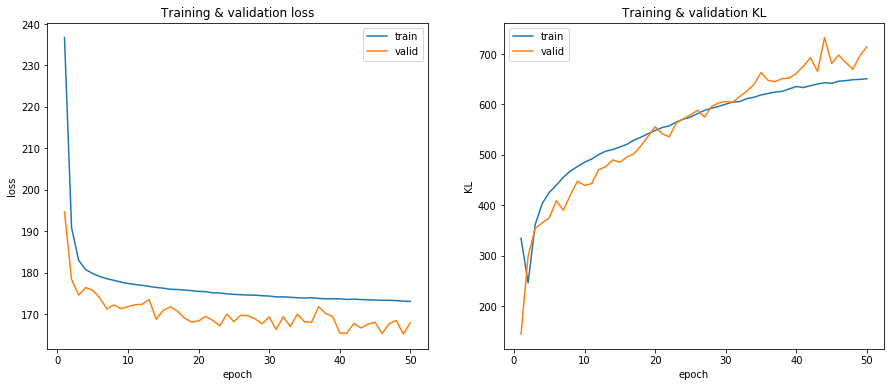

In [329]:
net.eval()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax[0], label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax[0], label="valid")
ax[0].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss")

sns.lineplot(x=x, y=train_kl, ax=ax[1], label="train")
sns.lineplot(x=x, y=valid_kl, ax=ax[1], label="valid")
ax[1].set(xlabel="epoch",
          ylabel="KL",
          title="Training & validation KL")

### Latent space visualization

In [330]:
images.shape

torch.Size([64, 1, 28, 28])

In [331]:
from sklearn.decomposition import PCA

agg_mu = torch.tensor([])
agg_mu_1 = []
agg_mu_2 = []
agg_l = []

with torch.no_grad():
    it = iter(test_loader)
    for i in range(50):
        images, labels = next(it)
        x = images.view(images.shape[0], -1)
        latent_mu, _ = torch.chunk(net.encoder(x), 2, dim=-1)
        agg_mu = torch.cat((agg_mu, latent_mu), dim=0)
        if latent_mu.shape[1] > 2:
            latent_mu = PCA(n_components=2).fit_transform(latent_mu.numpy())
        agg_mu_1 += list(latent_mu[:,0])
        agg_mu_2 += list(latent_mu[:,1])
        agg_l += list(labels.numpy())

# pom_images, pom_labels = next(iter(test_loader))
# pom_images.shape, pom_labels.shape
len(agg_mu_1), len(agg_mu_2), len(agg_l), agg_mu.shape

(3200, 3200, 3200, torch.Size([3200, 2]))

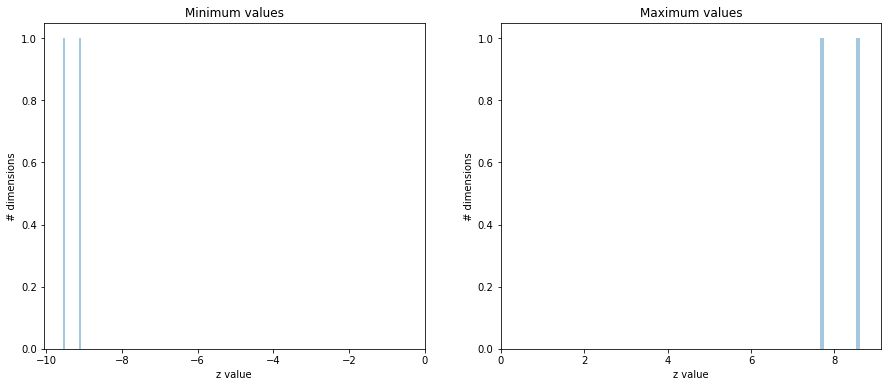

In [332]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mins = torch.min(agg_mu, dim=0).values.numpy()
sns.distplot(mins, bins=10, kde=False, ax=ax[0])
ax[0].set_xlim((mins.min() - 0.5, 0))
ax[0].set(xlabel="z value",
          ylabel="# dimensions",
          title="Minimum values")

maxs = torch.max(agg_mu, dim=0).values.numpy()
sns.distplot(maxs, bins=10, kde=False, ax=ax[1])
ax[1].set_xlim((0, maxs.max() + 0.5))
ax[1].set(xlabel="z value",
          ylabel="# dimensions",
          title="Maximum values")

plt.show()

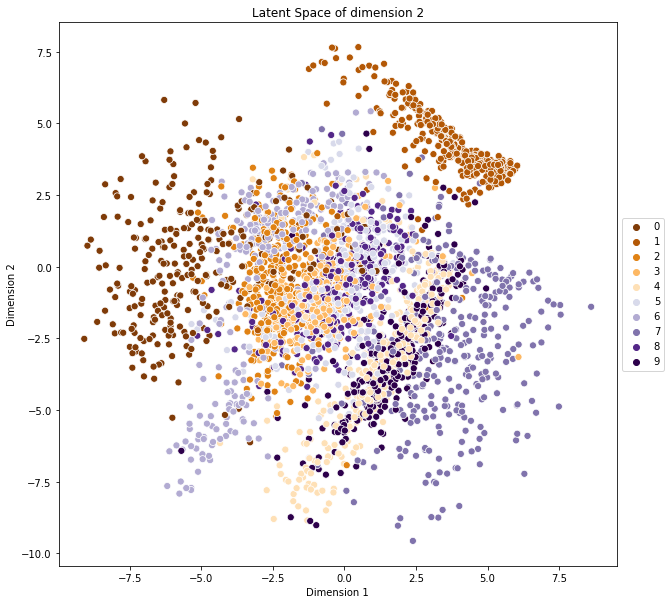

In [333]:
colors = ['#7f3b08','#b35806','#e08214','#fdb863','#fee0b6','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']
pal = sns.color_palette(colors)

f, ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(ax=ax, x=agg_mu_1, y=agg_mu_2, hue=agg_l, palette=pal, s=50)
ax.set_title('Latent Space of dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

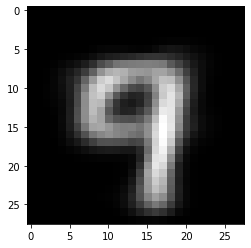

In [334]:
with torch.no_grad():
    z = torch.tensor([2.0, -5.0])
    plt.imshow(net.decoder(z).view(28,28), cmap='gist_gray')

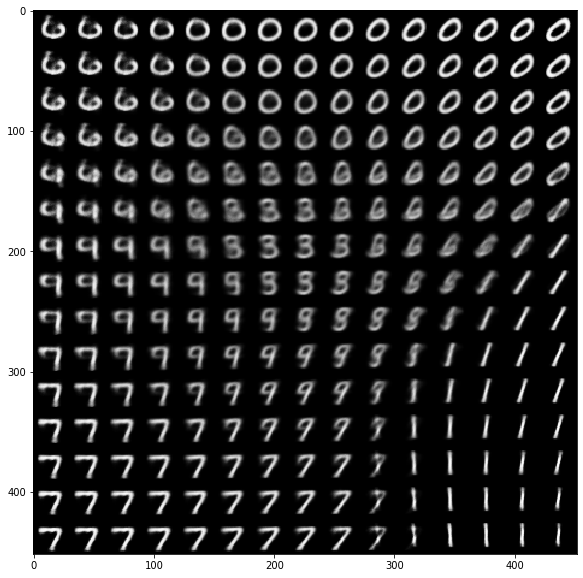

In [335]:
# sample images representing the whole latent space
n_samples_sqrt = 15

f, ax = plt.subplots(1, figsize=(10,10))
with torch.no_grad():
    xs = np.linspace(mins[0], maxs[0], num=n_samples_sqrt)
    ys = np.linspace(mins[1], maxs[1], num=n_samples_sqrt)
    
    sample = torch.tensor([(x, y) for x in xs for y in ys]).float()
    sample = net.decoder(sample).view(n_samples_sqrt**2,1,28,28)
    img = torchvision.utils.make_grid(sample, nrow=n_samples_sqrt).numpy()
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray_r')

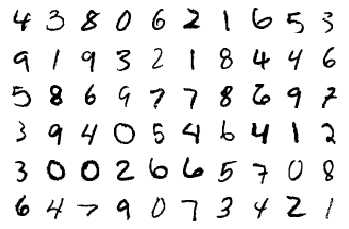

In [336]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

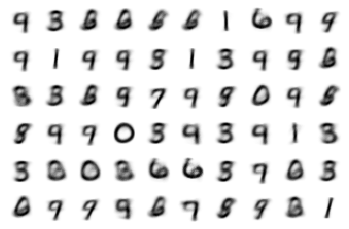

In [337]:
with torch.no_grad():
    x_hat, mu, log_var, z = net(images)
    figure = plt.figure()
    num_of_images = 60
    for index in range(1, num_of_images + 1):
        plt.subplot(6, 10, index)
        plt.axis('off')
        plt.imshow(x_hat[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Latent space samples
f, ax = plt.subplots(1)
ax.set_title('Samples from latent space')
ax.axis('off')

with torch.no_grad():
    epsilon = torch.from_numpy(grid).float().to(device)
    samples = torch.sigmoid(net.decoder(epsilon)).detach()

canvas = np.zeros((28*rows, columns*28))
for i in range(rows):
    for j in range(columns):
        idx = i % columns + rows * j
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
ax.imshow(canvas, cmap='gray')

In [173]:
epsilon.shape, z.shape

(torch.Size([64, 2]), torch.Size([64, 8]))

In [ ]:
train_loss, valid_loss

In [ ]:
len(val_loader)

In [ ]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    out_images, mu, log_var = net(images)
    imshow(torchvision.utils.make_grid(images))
    imshow(torchvision.utils.make_grid(out_images))
    print('GroundTruth: ', ' '.join('%5d' % labels[j] for j in range(8)))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(predicted)

In [ ]:
print(labels)

In [ ]:
(predicted == labels).squeeze()

In [ ]:
# generate new image based on latent space
with torch.no_grad():
    sample = torch.randn(64,10)
    sample = net.decoder(sample)
    imshow(torchvision.utils.make_grid(sample.view(64,1,28,28)))

In [ ]:
# find accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of class %d : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
net.zero_grad()  # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)